In [ ]:
# default_exp

In [ ]:
#hide
#all_slow

# 2-D posterior toy example

> Demonstration of posterior error bounds for a 2-D toy example, for various levels of sensor noise

In this notebook we will demonstrate the error bounds for the statFEM posterior for the toy example introduced in <a href="/statFEM/twoDim.html#2-dimensional-case-(PDE)"><code>twoDim</code></a>. We first import some required packages.

In [ ]:
from dolfin import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import matplotlib.tri as tri
plt.rcParams['figure.figsize'] = (10,6)
from scipy.linalg import sqrtm
import sympy; sympy.init_printing()
from tqdm.notebook import tqdm
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))
# import required functions from twoDim
from statFEM.twoDim import mean_assembler, kernMat, cov_assembler, m_post, gen_sensor, MyExpression, m_post_fem_assembler, c_post, c_post_fem_assembler

Since we again to not have access to the true distribution we will use the method outlined in the section <a href="/statFEM/twoDim_prior_results.html"><code>2-D prior toy example</code></a> to approximate the convergence rate. We now set up the required code.

First we set up the mean and kernel functions for the random forcing term $f$.

In [ ]:
# set up mean and kernel functions
f_bar = Constant(1.0)

l_f = 0.4
σ_f = 0.1

def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

def m_f(x):
    return 1.0

We now set up a reference grid on which we will compare the covariance matrices.

In [ ]:
N = 41
x_range = np.linspace(0,1,N)
grid = np.array([[x,y] for x in x_range for y in x_range])
# plt.scatter(grid[:,0],grid[:,1])
# plt.grid()
# plt.show()

Let's estimate the prior variances at the grid points by using the statFEM prior. We will use this estimate to set an appropriate noise level.

In [ ]:
%%time
grid_vars = np.diag(cov_assembler(50,k_f,grid,False,True))

CPU times: user 1.41 s, sys: 158 ms, total: 1.57 s
Wall time: 1.56 s


In [ ]:
#hide_input
pd.DataFrame({'Prior variance':grid_vars}).describe()

,Prior variance
count,1681.000000
mean,0.000011
std,0.000011
min,0.000000
25%,0.000001
50%,0.000007
75%,0.000019
max,0.000037


Let's set the sensor noise level to a value in the range of the prior grid variances.

In [ ]:
ϵ = 0.001

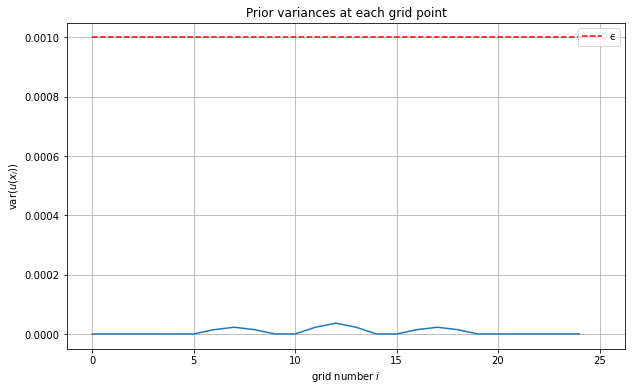

In [ ]:
#hide_input
plt.plot(grid_vars)
plt.hlines(ϵ,0,len(grid),colors='red',linestyles='--',label='ϵ')
plt.xlabel('grid number $i$')
plt.ylabel('$\operatorname{var}(u(x_{i}))$')
plt.title('Prior variances at each grid point')
plt.legend()
plt.grid()
plt.show()

We now set up the sensor grid and generate some sensor data.

In [ ]:
s = 25
s_sqrt = int(np.round(np.sqrt(s)))
Y_range = np.linspace(0.01,0.99,s_sqrt)
Y = np.array([[x,y] for x in Y_range for y in Y_range])
J_fine = 100
np.random.seed(42)
v_dat = gen_sensor(ϵ,m_f,k_f,Y,J_fine,False,True)

We now set up a function to get the statFEM posterior for a FE mesh size $h$, using functions from <a href="/statFEM/twoDim.html#"><code>twoDim</code></a>.

In [ ]:
def fem_prior(h,f_bar,k_f,grid):
    J = int(np.round(1/h))
    μ = mean_assembler(h,f_bar)
    μ_vect = np.array([μ(x) for x in grid])
    Σ = cov_assembler(J,k_f,grid,False,True)
    return μ_vect,Σ

In [ ]:
def fem_posterior(h,f_bar,k_f,ϵ,Y,v_dat,grid):
    J = int(np.round(1/h))
    m_post_fem = m_post_fem_assembler(J,f_bar,k_f,ϵ,Y,v_dat)
    μ = MyExpression()
    μ.f = m_post_fem
    μ_vect = np.array([μ(x) for x in grid])
    Σ = c_post_fem_assembler(J,k_f,grid,Y,ϵ,False,True)
    return μ_vect,Σ

In [ ]:
%%time
h = 0.1
μ_prior, Σ_prior = fem_prior(h,f_bar,k_f,grid)
μ_posterior, Σ_posterior = fem_posterior(h,f_bar,k_f,ϵ,Y,v_dat,grid)

CPU times: user 6.65 s, sys: 15.6 s, total: 22.2 s
Wall time: 2.94 s


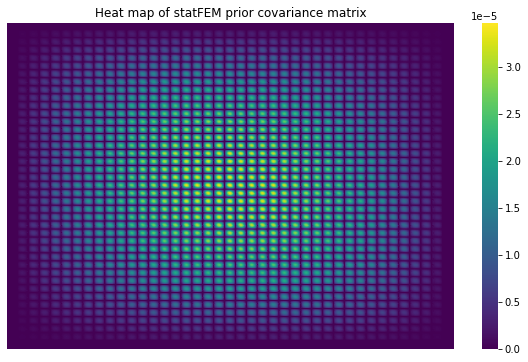

In [ ]:
sns.heatmap(Σ_prior,cbar=True,
              annot=False,
              xticklabels=False,
              yticklabels=False,
              cmap=cm.viridis)
plt.title('Heat map of statFEM prior covariance matrix')
plt.show()

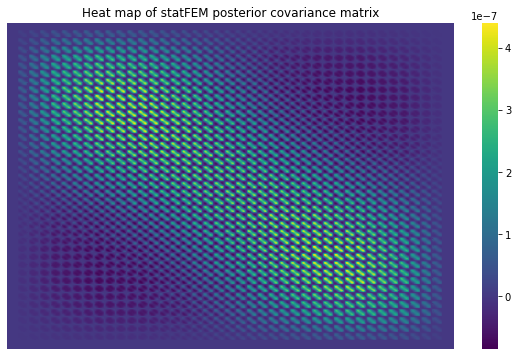

In [ ]:
sns.heatmap(Σ_posterior,cbar=True,
              annot=False,
              xticklabels=False,
              yticklabels=False,
              cmap=cm.viridis)
plt.title('Heat map of statFEM posterior covariance matrix')
plt.show()

In [ ]:
pd.DataFrame({'prior':np.diag(Σ_prior)}).describe()

,prior
count,1.681000e+03
mean,9.806986e-06
std,1.004928e-05
min,0.000000e+00
25%,9.736806e-07
50%,6.169852e-06
75%,1.698341e-05
max,3.468923e-05


In [ ]:
pd.DataFrame({'posterior':np.diag(Σ_posterior)}).describe()

,posterior
count,1.681000e+03
mean,2.162100e-07
std,1.472237e-07
min,0.000000e+00
25%,5.046952e-08
50%,2.534848e-07
75%,3.499279e-07
max,4.404419e-07


In [ ]:
def W_sliced(μ_1,μ_2,Σ_1,Σ_2,g):
    # get length of grid from length of μ_i
    N = len(μ_1)
    
    # form mean error term
    mean_error = (g @ (μ_1 - μ_2))**2
    
    # form var error term
    var_error = (np.sqrt(g @ Σ_1 @ g) - np.sqrt(g @ Σ_2 @ g))**2
    
    # compute and return error
    return (1/N)*np.sqrt(mean_error + var_error)

In [ ]:
def g_l(x):
    x = 2*np.pi * x
    return np.sin(x[0])*np.sin(x[1])

In the interests of memory efficiency we will again create a function which will compute the ratios of errors by succesively refining the FE mesh as done in the section <a href="/statFEM/twoDim_prior_results.html"><code>2-D prior toy example</code></a>.

In [ ]:
def refine(h,n,f_bar,k_f,ϵ,Y,v_dat,grid,g_l):
    # set up vector g
    g = np.array([g_l(x) for x in grid])
    
    # set up empty lists to hold h-values and errors (this being the ratios)
    h_range = []
    errors = []
    
    # get the statFEM posterior for h and h/2
    μ_1, Σ_1 = fem_posterior(h,f_bar,k_f,ϵ,Y,v_dat,grid)
    μ_2, Σ_2 = fem_posterior(h/2,f_bar,k_f,ϵ,Y,v_dat,grid)
    
    # compute the distance between these and store in numerator variable
    numerator = W_sliced(μ_1,μ_2,Σ_1,Σ_2,g)
    
    # succesively refine the mesh by halving and do this n times
    for i in tqdm(range(n)):
        # store mean and cov for h/2 in storage for h
        μ_1, Σ_1 = μ_2, Σ_2
        # in storage for h/2 store mean and cov for h/4
        μ_2, Σ_2 = fem_posterior(h/4,f_bar,k_f,ϵ,Y,v_dat,grid)
        
        # compute the distance between the posteriors for h/2 and h/4
        # and store in denominator variable
        denominator = W_sliced(μ_1,μ_2,Σ_1,Σ_2,g)
        # compute the ratio and store in error
        error = numerator/denominator
        # append the current value of h and the ratio
        h_range.append(h)
        errors.append(error)
        # store denominator in numerator and halve h
        numerator = denominator
        h = h/2
    # return the list of h-values together with the ratios for these values
    return h_range,errors

We now set up a list of starting $h$ values and number of refinements $n$ to get a decent number of ratios to approximate $p$. We also set up the `J_norm` variable needed to control the grid on which the mean error is computed in the Wasserstein distance.

In [ ]:
my_list = [(0.25,4),(0.2,3),(0.175,3),(0.176,3),(0.177,3),(0.178,3),(0.179,3),(0.18,3),(0.21,3),(0.215,3),(0.1,2),(0.3,4),(0.31,4),(0.315,4),(0.24,3),(0.245,3),(0.14,2),(0.16,2),(0.15,2)]

We now compute the results: 

In [ ]:
%%time
h_range = []
errors = []
np.random.seed(235)
for h,n in tqdm(my_list,desc='Outer loop'):
    h_range_tmp, errors_tmp = refine(h,n,f_bar,k_f,ϵ,Y,v_dat,grid,g_l)
    h_range.extend(h_range_tmp)
    errors.extend(errors_tmp)

Outer loop:   0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 27min 23s, sys: 37min 8s, total: 1h 4min 31s
Wall time: 20min 5s


We now sort these results by $h$.

In [ ]:
#hide
# import pickle
# results = {'h':h_range,'ratios':errors,'ϵ':ϵ}
# with open('2D_posterior_results_finer_less_noise','wb') as f:
#     pickle.dump(results,f)

In [ ]:
#hide
# import pickle
# with open('2D_posterior_results_finer','rb') as f:
#     results = pickle.load(f)
# h_range = results['h']
# errors = results['ratios']

In [ ]:
h_range_array = np.array(h_range)
errors_array = np.array(errors)

In [ ]:
argInd = np.argsort(h_range_array)
hs = h_range_array[argInd]
es = errors_array[argInd]
hs,hs_ind = np.unique(hs,return_index=True)
es = es[hs_ind]

We now plot the base-2 logarithm of the ratios against $h$ below:

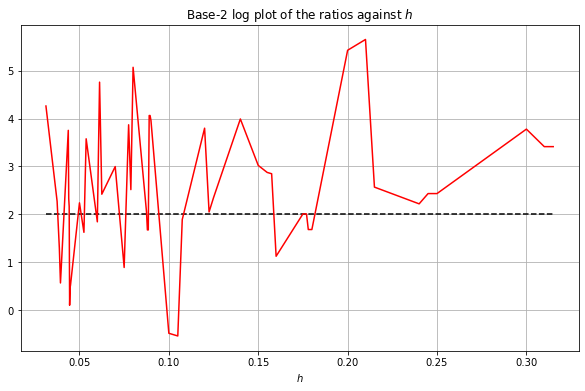

In [ ]:
#hide_input
plt.plot(hs,np.log2(es),c='r')
plt.xlabel('$h$')
plt.title('Base-2 log plot of the ratios against $h$')
plt.hlines(2.0,hs[0],hs[-1],colors='black',linestyles='--')
plt.grid()
#plt.savefig('2D_posterior_results.png',dpi=300,bbox_inches='tight',facecolor='w')
plt.show()

We can see from the above plot that the logarithms seems to be approaching $p=2$ as $h$ gets small just as predicted. However, the results aren't that smooth and they haven't seemed to settle on $p=2$ yet. This can be due to memory constraints meaning we cannot use small enough $h$. We thus smooth the above results via two approaches:

- We take a cumulative average of the ratios and then apply $\log_2$.
- We first apply $\log_2$ to the ratios and then taking a cumulative average.

In both cases we take the rolling average starting with large $h$. We choose a cut-off point of $h=0.15$, i.e. we discard any results for $h>0.15$.

The results are shown below:

From the smoothed results above we can see more clearly that the ratios are converging to around $p=2$.

In [ ]:
hs[:-18]

array([0.03125 , 0.0375  , 0.03875 , 0.039375, 0.04375 , 0.044   ,
       0.04425 , 0.0445  , 0.04475 , 0.045   , 0.05    , 0.0525  ,
       0.05375 , 0.06    , 0.06125 , 0.0625  , 0.07    , 0.075   ,
       0.0775  , 0.07875 , 0.08    , 0.0875  , 0.088   , 0.0885  ,
       0.089   , 0.0895  , 0.09    , 0.1     , 0.105   , 0.1075  ,
       0.12    , 0.1225  , 0.125   , 0.14    , 0.15    ])

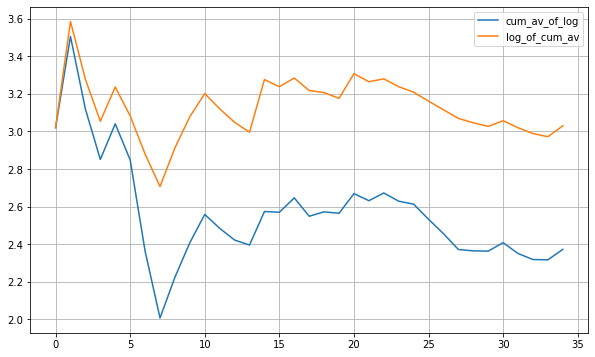

In [ ]:
#hide_input
# get the cumulative average of es:
i = -18
es_trimmed = es[:i]
es_av = np.cumsum(np.log2(es_trimmed[::-1]))/np.arange(1,len(es_trimmed)+1)
es_av_1 = np.log2(np.cumsum(es_trimmed[::-1])/np.arange(1,len(es_trimmed)+1))
plt.plot(es_av,label='cum_av_of_log')
plt.plot(es_av_1,label='log_of_cum_av')
#plt.plot(es_av_1,c='r')
#plt.hlines(2.0,0,len(es_av_1),colors='black',linestyles='--')
#plt.ylim((1.8,2.1))
#plt.xlabel('index')
plt.legend()
#plt.title('Base-2 logarithms of the cumulative averages of the ratios for $h\leq 0.15$')
plt.grid()
#plt.savefig('2D_posterior_results_smoothed.png',dpi=300,bbox_inches='tight',facecolor='w')
plt.show()

From the smoothed results above we can see more clearly that the ratios are converging to around $p=2$. In fact, discarding the values corresponding to $h>0.15$ seems to result in the the rolling average converging to a value slightly greater than $2$.